# 理論部分
## CGANの構造
- 一番期待するのは、Generatorはどのようにy labelを自分のネットワークに込めるんだろう。
- 注意すべきこと、(x,y)のセットがDiscriminatorの入力データ。出力はreal, fakeです。
 - Supervised学習だと、xがネットワークの入力、yが出力です。

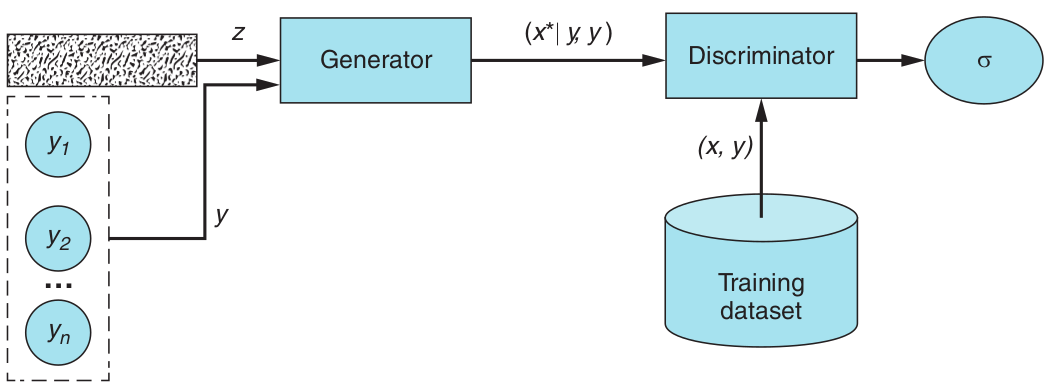

In [1]:
from IPython.display import Image
Image("img/cgan-2020-02-29 15-10-45.png")

## CGANは何をしたい？
- Generatorのアウトプットをcontrolしたい。そのcontrol情報はconditionという。
- この付け加える情報は、なんでもOK。例えば、a class label, a set of tags, or even a written description.
 - 今回の例ではclass labelを使っている。

## Generatorの２つ目標（Discriminatorの２つ目標も分かる）
- realistic-looking dataを生成する。
- 生成したデータは、y labelとmatchする。

## Generatorのy labelの使い方
- Embedding and element-wise multiplication.
 - Embedding: take label y and turn it into a dense vector of size z_dim (the length of the random noise vector).

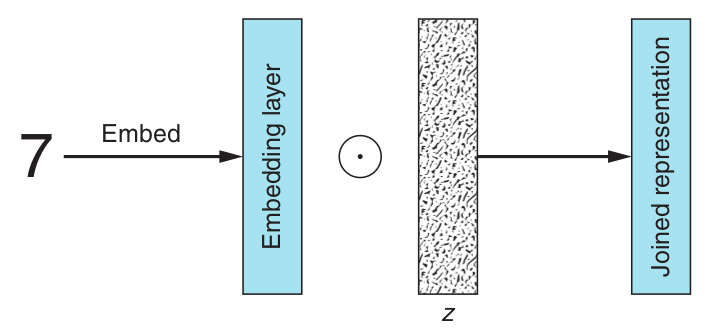

In [12]:
Image("img/cgan-combine-label-and-z-2020-02-29 18-11-34.png")

## Embeddingの例
- 参考：https://keras.io/layers/embeddings/
- 普段はword embeddingとして使われる。つまりinput_dimはoutput_dimよりだいぶ大きい。
 - one-hotでwordをencodeすると、デッカいので。
- ここで特別でinput_dimは10（数字が0~9）、output_dimは100（random noise zのサイズ）。
- 注意：
 - Embeddingの入力tensorは(batch_size, input_length)。下の例だと(4,1)。
 - the largest integer (i.e. word index) in the input should be no larger than input_dim (vocabulary size).
     - 下の例だと、vocabulary sizeはnum_classes(10)なので、labelはno larger than 9.
 - Embeddingの出力tensorは(batch_size, input_length, output_dim)。下の例だと(4,1,z_dim),(4,1,100)
 - input_lengthが必要な場合：
     - This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).
     - 今回はEmbeddingの次はFlattenなので、input_lengthは必要。(batch_size,1,z_dim)の真ん中の1を消すために。zのサイズ(batch_size,z_dim)に合わせるために。

In [5]:
import numpy as np
from keras.layers import Embedding
from keras.models import Sequential

In [9]:
batch_size = 4
z_dim = 100
num_classes = 10

model = Sequential()
model.add(Embedding(num_classes, z_dim, input_length=1))
# 0~9のy label batchを生成する
labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
model.compile('rmsprop', 'mse')
output_labels = model.predict(labels)
assert output_labels.shape == (batch_size, 1, z_dim)

In [10]:
print(labels) # batch_size * 1
print(output_labels) # batch_size * 1 * z_dim

[[0]
 [6]
 [4]
 [8]]
[[[ 0.03712255  0.03812785 -0.02047029 -0.04238396  0.00043427
    0.01446709  0.00417145 -0.0236241   0.0105715  -0.0157675
   -0.01773002  0.03429425 -0.0080323  -0.03029941  0.03576701
    0.02780905 -0.04113944 -0.04659129 -0.02608448 -0.03372729
    0.03495706  0.02998462 -0.04373368  0.00789087 -0.02369891
    0.00084854  0.04561322  0.04603614  0.04417323 -0.02792803
   -0.03706778 -0.03656548 -0.00275513 -0.0025066   0.00782292
    0.04856913 -0.04727573 -0.02740141 -0.01246224  0.02827007
    0.03757702  0.04512889  0.03300413  0.04745967 -0.01769105
   -0.01907235  0.03358007 -0.02738377  0.04215993  0.01847415
   -0.00312923  0.00539453  0.02994012  0.03744267 -0.00105238
    0.0205557   0.00749248  0.01454929 -0.04519347  0.01067657
    0.01522327  0.0165031   0.01173074 -0.0346277   0.04923196
    0.00426101 -0.01381166 -0.01679892 -0.04927874 -0.04975308
   -0.00548419 -0.03679546 -0.01062552 -0.04166975  0.02279992
    0.0139224   0.03296492 -0.02243

## Discriminatorのy labelの使い方
- 同じくEmbeddingでlabelを28x28x1=784に拡張する。
- 最終的に(x,y)セットは(28x28x2)のインプットになっている。
- 面白いのは、GeneratorでMultiplication、ここはConcatenateを使っている、ふふふ。

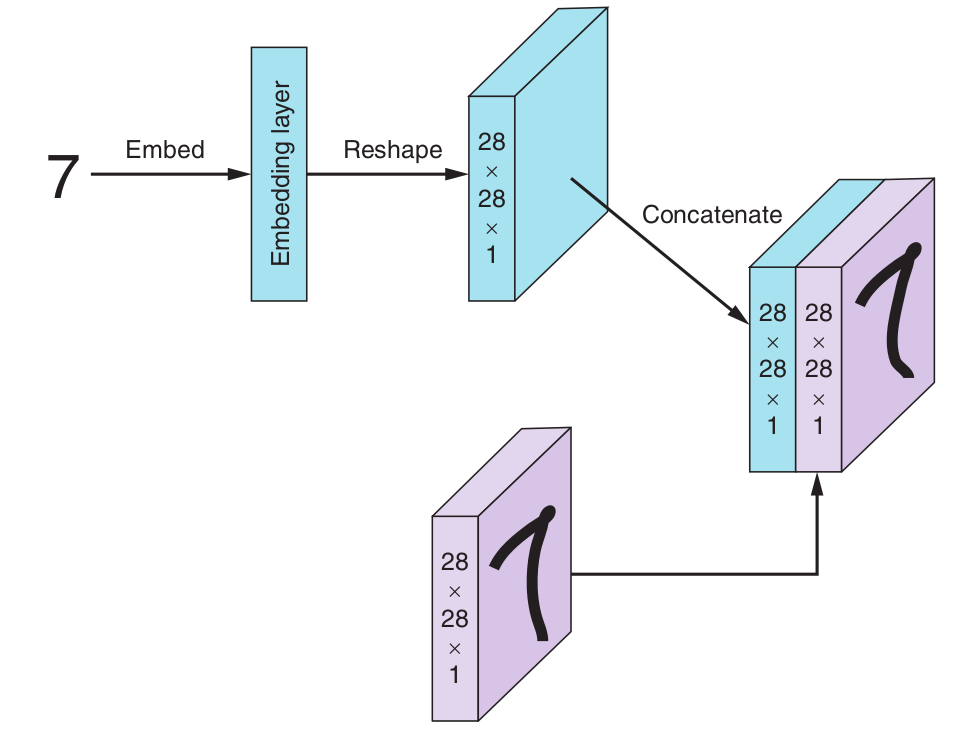

In [11]:
Image("img/cgan-combine-label-and-image-2020-02-29 19-13-20.png")

## インプットサイズの変更に合わせるDiscriminatorの変更点（DCGANと比べる）
- Discriminatorモデルのインプットサイズを(28x28x2)に変更する。
- 1つ目convolutional layerのdepthを32から64にする。なぜならインプットのdepthが2倍になっているから。情報漏れないように。

## Conditional GANの応用
- image-to-image translation.
 - translate images from one modality into another.
 - 応用例：
     - colorizing black-and-white photos.
         - 例えばinputはa black-and-white photo。labelはa colored version of the same photo.
     - turning a daytime scene into nighttime.
     - synthesizing a satellite view from a map view.
 - 最初の印象が残る実現はpix2pixですが、1年後完全にCycleGANに圧倒された。
     - Only about a year after pix2pix's publication, it was eclipsed by CycleGAN that not only outperformed pix2pix's performance on image-to-image translation tasks but also accomplised it **without the need for paired images**.
     - The Cycle-Consistent Adversarial Network needs only two groups of images representing the two domains (for example, a group of black-and-white photos and a group of colored photos.)
         - つまり２つdomainのたくさんの画像数は変わらないが、pairする必要がなくなった。そもそもpairって大変でしょう。

# 実装部分

In [13]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                         Embedding, Flatten, Input, Multiply, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [14]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100
num_classes = 10

## Step 1: Generator - input: (z, label)
- 処理流れ
 - $label \overset{embedding}{\rightarrow} z\_label $
     - $(batch\_size,1)\overset{embedding}{\rightarrow} (batch\_size,z\_dim)$
 - $z, z\_label \overset{multiplication}{\rightarrow} z\_joint$
     - $(batch\_size, z\_dim), (batch\_size, z\_dim) \overset{multiplication}{\rightarrow} (batch\_size, z\_dim)$
 - $z\_joint \overset{generator}{\rightarrow} \hat{x}$
     - $(batch\_size, z\_dim) \overset{generator}{\rightarrow} (batch\_size, img\_shape)$

In [15]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256))) # 7x7x256
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')) # 14x14x128
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same')) # 14x14x64
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same')) # 28x28x1
    model.add(Activation('tanh'))
    return model

- Flatten層：Flattens the input. **Does not affect the batch size**.
 - だからFlattenで(batch_size,1,z_dim)3D tensorを(batch_size,z_dim)2D tensorに変換できる。

In [17]:
def build_cgan_generator(z_dim):
    # ２つInputなので、２つInput層が必要
    z = Input(shape=(z_dim, )) # (batch_size,z_dim)
    label = Input(shape=(1, ), dtype='int32') # (batch_size,1)
    
    # labelのembedding及びzとのmultiplication
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label) # (batch_size,1,z_dim)
    label_embedding = Flatten()(label_embedding) # (batch_size,z_dim)
    joined_representation = Multiply()([z, label_embedding])
    
    # 画像を生成する
    generator = build_generator(z_dim)
    conditioned_img = generator(joined_representation)
    
    return Model([z, label], conditioned_img)

## Step 2: Discriminator - input (x, label)
- 処理流れ
 - $label \overset{embedding,reshape}{\rightarrow} x\_label$
     - $(batch\_size,1) \overset{embedding,reshape}{\rightarrow} (batch\_size,img\_shape)$
 - $x,x\_label \overset{concatenate}{\rightarrow} x\_concatenated$
     - $(batch\_size,img\_shape),(batch\_size,img\_shape) \overset{concatenate}{\rightarrow} (batch\_size,img\_rows,img\_cols,2\times channels)$
     - Generatorのやり方と違う。Generatorはlabelを含める時zのサイズを変えない。ここはlabelを含める時xのサイズを2倍にしている。
 - $x\_concatenated \overset{discriminator}{\rightarrow} p_{real}$
     - $(batch\_size,img\_rows,img\_cols,2\times channels) \overset{discriminator}{\rightarrow} (batch\_size,1)$

In [18]:
def build_discriminator(img_shape):
    model = Sequential()
    # Discriminator開始のinputサイズが変わったので、input_shapeを少し変更
    model.add(Conv2D(64, kernel_size=3, strides=2,
                    input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),
                    padding='same')) # 28x28x2 -> 14x14x64
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same')) # 7x7x64
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same')) # 3x3x128
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [19]:
def build_cgan_discriminator(img_shape):
    # ２つInput
    img = Input(shape=img_shape)
    label = Input(shape=(1, ), dtype='int32')
    
    # Embedding, Reshape, Concatenate
    label_embedding = Embedding(num_classes, np.prod(img_shape),
                                input_length=1)(label) # (batch_size, 1, 28*28*1)
    label_embedding = Flatten()(label_embedding) # (batch_size, 28*28*1)
    label_embedding = Reshape(img_shape)(label_embedding)
    concatenated = Concatenate(axis=-1)([img, label_embedding])
    
    # Discriminate
    discriminator = build_discriminator(img_shape)
    classification = discriminator(concatenated)
    
    return Model([img, label], classification)

## Step 3: CGAN, DiscriminatorやCGANのcompile

In [20]:
def build_cgan(generator, discriminator):
    # Generatorのinputと同じ
    z = Input(shape=(z_dim, ))
    label = Input(shape=(1, ))
    img = generator([z, label])
    classification = discriminator([img, label])
    model = Model([z, label], classification)
    return model

In [21]:
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])
generator = build_cgan_generator(z_dim)
discriminator.trainable = False
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Step 4: Training

In [22]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3) # channels軸を追加、１だけど。
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for iteration in range(iterations):
        # -------------------------
        # Discriminatorのトレーニング
        # -------------------------
        
        # real imagesやlabels batch
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]
        
        # generated fake imagesやlabels batch（labelsは上記と一緒）
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])
        
        # train the Discriminator
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ---------------
        # Generatorのトレーニング
        # ----------------
        
        # generated imagesやlabels batch
        z = np.random.normal(0, 1, (batch_size, z_dim))
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        
        # train the Generator
        g_loss = cgan.train_on_batch([z, labels], real)
        
        if (iteration + 1) % sample_interval == 0:
            # discriminatorをコンパイルするとき、accuracy metricを入れたので、d_lossは[loss, accuracy]になっている。
            print("%d [D loss: %f, accuracy: %.2f%%] [G loss: %f]" %
                 (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss)) 
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])
            sample_images()

In [28]:
def sample_images(image_grid_rows=2, image_grid_columns=5, figsize=(10, 4), labels=np.arange(0,10)):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    labels = labels.reshape(-1, 1) # 0~9 labelで画像を生成する。
    
    gen_imgs = generator.predict([z, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5 # from [-1,1] to [0,1]
    
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=figsize,
                           sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.001901, accuracy: 100.00%] [G loss: 12.546865]
2000 [D loss: 0.049368, accuracy: 98.44%] [G loss: 10.894066]
3000 [D loss: 0.202045, accuracy: 90.62%] [G loss: 0.910518]
4000 [D loss: 0.046403, accuracy: 100.00%] [G loss: 3.949348]
5000 [D loss: 0.075603, accuracy: 96.88%] [G loss: 5.077364]
6000 [D loss: 0.106473, accuracy: 98.44%] [G loss: 0.459180]
7000 [D loss: 0.190738, accuracy: 92.19%] [G loss: 2.217327]
8000 [D loss: 0.083279, accuracy: 96.88%] [G loss: 2.754292]
9000 [D loss: 0.021718, accuracy: 100.00%] [G loss: 3.037167]
10000 [D loss: 0.065344, accuracy: 98.44%] [G loss: 0.406078]
11000 [D loss: 0.024621, accuracy: 100.00%] [G loss: 6.970421]
12000 [D loss: 0.042969, accuracy: 100.00%] [G loss: 3.027821]


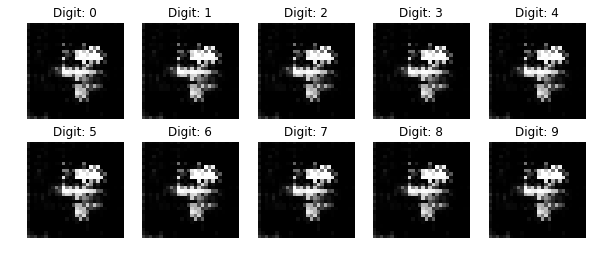

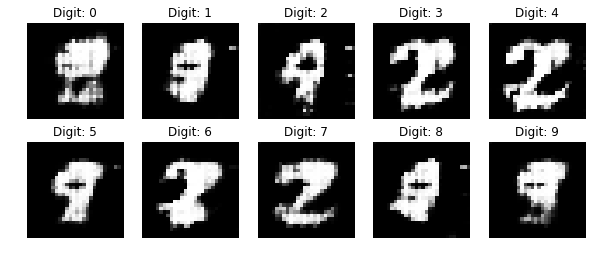

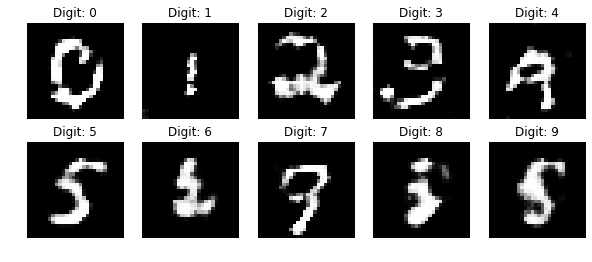

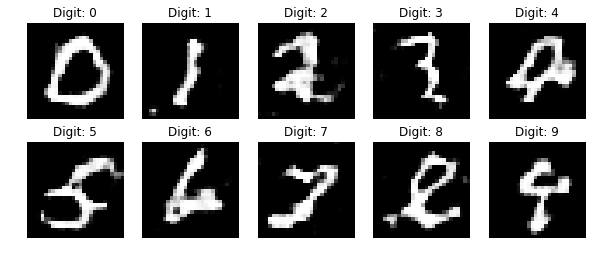

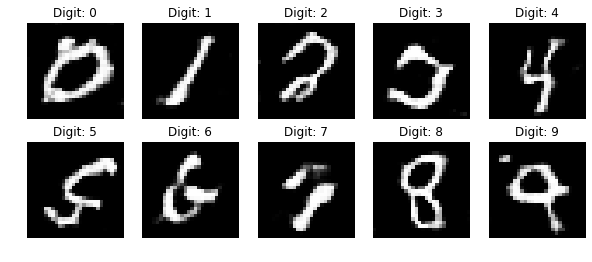

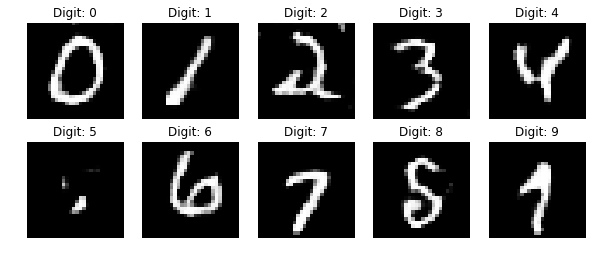

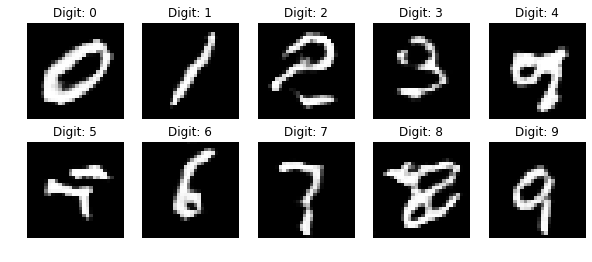

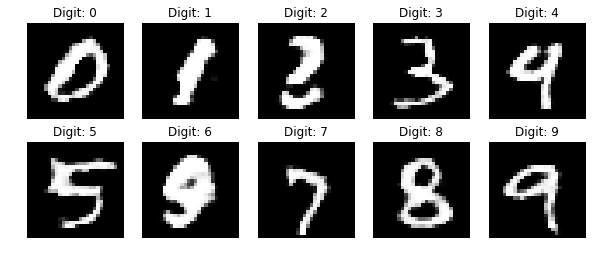

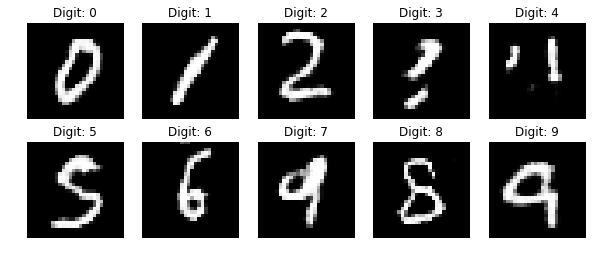

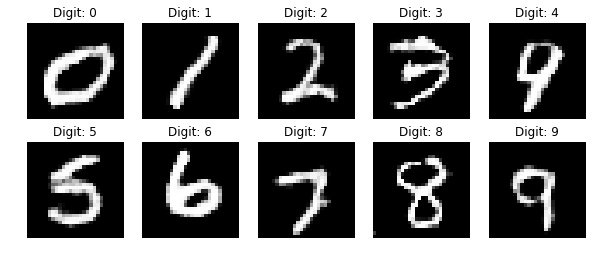

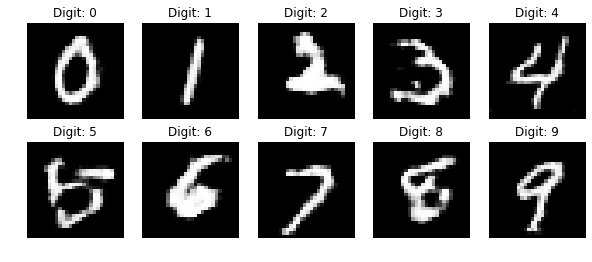

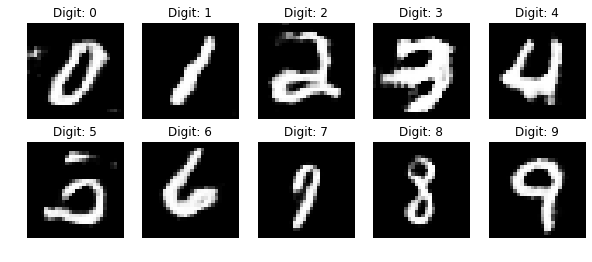

In [25]:
iterations = 12000
batch_size = 32
sample_interval = 1000
train(iterations=iterations, batch_size=batch_size, sample_interval=sample_interval)
cgan.save_weights('cgan.h5')
generator.save_weights('cgan_generator.h5')

## Step 5: 学習済みCGANの生成器を使おう

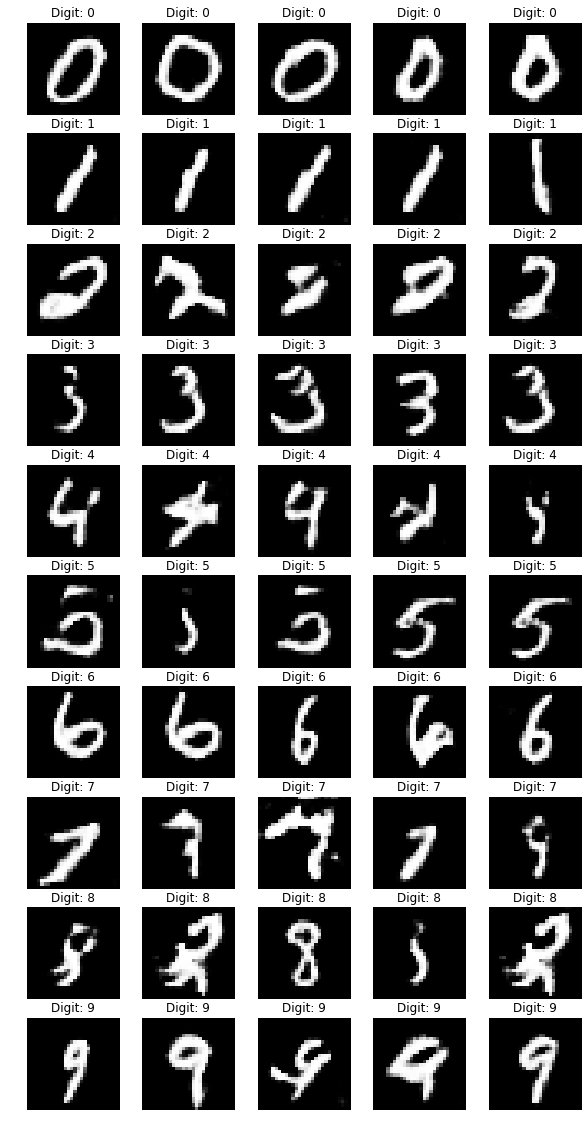

In [30]:
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
sample_images(image_grid_rows=10, image_grid_columns=5, figsize=(10,20), labels=labels_to_generate.flatten())